In [136]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.ndimage import uniform_filter1d
from scipy.optimize import curve_fit
from scipy import integrate
from mpl_toolkits.mplot3d import Axes3D
from matplotlib import cm

In [2]:
def conv_energy(x):
    energy=0.000002*x**2 - 0.0003 * x + .1265
    return energy

In [3]:
filename_cam='datasets/galadriel_dataset_24_06_28_cam.npy'

In [4]:
#read the data
with open(filename_cam,'rb') as f:
    camera_list=np.load(f)
    
#get the background array
background=camera_list[0]
camera_list=camera_list[1:]
#substract the background
camera_list=camera_list.astype(np.int16)-background.astype(np.int16)
camera_list[camera_list<0]=0 #remove negative values

In [5]:
print(camera_list[0])
print(background)
#print(camera_list[0].astype(np.int16)-background.astype(np.int16))

[[13  7  0 ...  0  6  0]
 [11  3  4 ...  3  0  1]
 [ 0 17  0 ...  2  0  4]
 ...
 [ 0  0 17 ...  0  3  5]
 [ 5  0  4 ...  0  1  0]
 [21  0  4 ...  0  1  5]]
[[ 91  94  97 ... 105  86 116]
 [182 190 187 ... 197 176 211]
 [202 199 204 ... 207 195 219]
 ...
 [194 196 178 ... 196 188 202]
 [197 193 194 ... 203 177 208]
 [187 196 185 ... 196 179 202]]


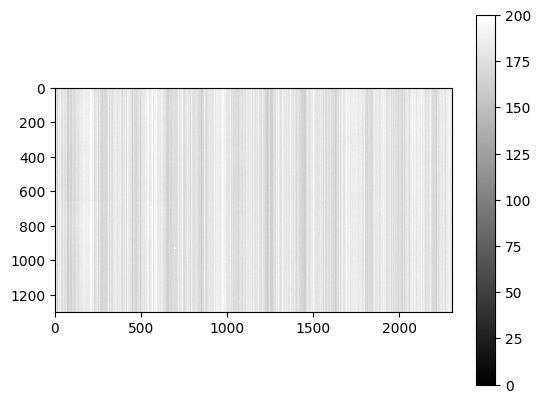

In [6]:
plt.imshow(background,cmap='gray',vmin=0,vmax=200)
plt.colorbar(orientation='vertical')

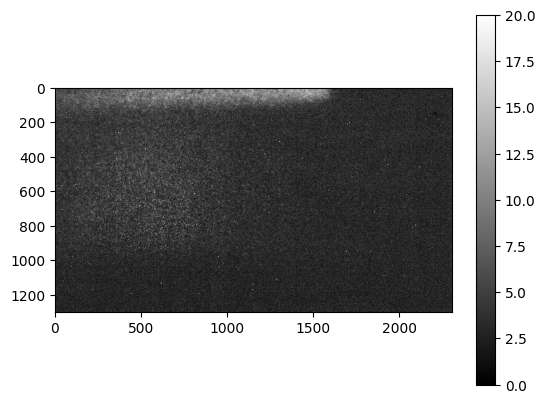

In [7]:
plt.imshow(camera_list[10],cmap='gray',vmin=0,vmax=20)
plt.colorbar(orientation='vertical')

In [8]:
##Reduce to the central section
camera_list.shape
minval=400
maxval=800
camera_reduced=camera_list[:,minval:maxval,:]

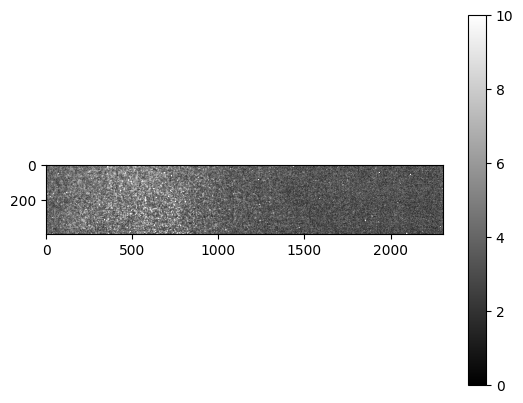

In [9]:
plt.imshow(camera_reduced[10],cmap='gray',vmin=0,vmax=10)
plt.colorbar(orientation='vertical')

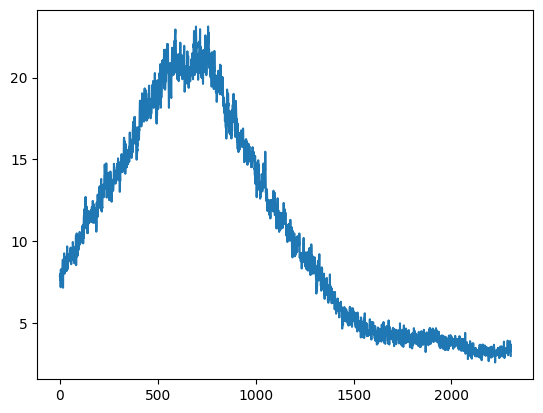

In [10]:
y=np.average(camera_reduced[0,:,:],axis=0)
#y = uniform_filter1d(y, size=10)
#y2=uniform_filter1d(camera_reduced[0,100,:],size=10)
plt.plot(y)
#plt.plot(y2)

# Analysis all camera set

In [11]:
filename='datasets/galadriel_dataset_24_06_28_phys.h5'

In [12]:
df_input=pd.read_hdf(filename,'df_input')
df_camera=pd.read_hdf(filename,'df_camera')


#get the arrays and print them
print('Input DF')
print(df_input)

print('----')
print('Camera 1D')
print(df_camera)

Input DF
      shot number   order2   order3     order4
0          152354  34900.0 -17000.0 -4600000.0
1          152355  34900.0 -17000.0 -4600000.0
2          152356  34900.0 -17000.0 -4600000.0
3          152357  34900.0 -17000.0 -4600000.0
4          152358  34900.0 -17000.0 -4600000.0
...           ...      ...      ...        ...
3068       155422  35400.0  28000.0 -3700000.0
3069       155423  35400.0  28000.0 -3700000.0
3070       155424  35400.0  28000.0 -3700000.0
3071       155425  35400.0  28000.0 -3700000.0
3072       155426  35400.0  28000.0 -3700000.0

[3073 rows x 4 columns]
----
Camera 1D
         0        1        2        3        4        5        6        7     \
0      7.8350   7.7175   7.6275   8.0125   7.1775   8.2700   7.6475   8.2300   
1      4.9625   5.3575   5.0575   5.3150   4.9625   5.2625   5.0600   5.4075   
2      5.7550   5.4150   5.5075   5.9650   5.5225   6.1475   5.5550   5.5625   
3      6.6550   6.9925   6.4275   7.1600   6.5275   7.0425   7.0100

### Smooth the data

In [13]:
#smooth the whole camera dataframe
df_camera_smooth=df_camera.apply(uniform_filter1d,axis=1,size=10,result_type='broadcast')

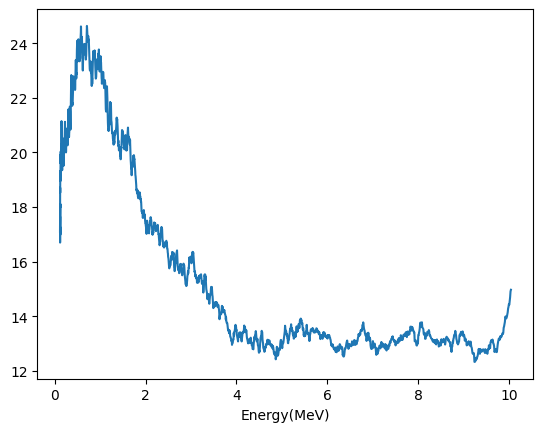

Text(0.5, 0, 'Pixels')

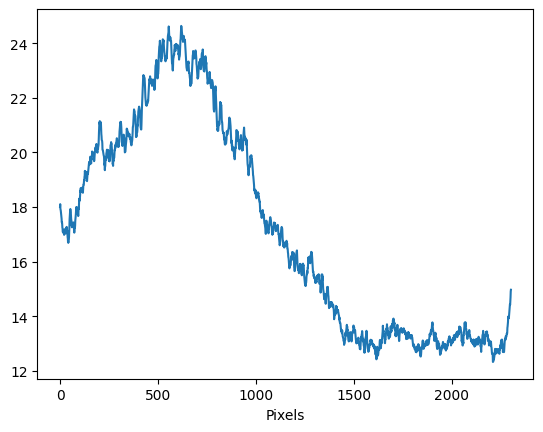

In [14]:
e_dist=df_camera_smooth.loc[1000]
x=np.linspace(0,len(df_camera.columns)-1,len(df_camera.columns))
MeV = 0.000002*x**2 - 0.0003 * x + .1265
plt.plot(MeV,e_dist)
plt.xlabel('Energy(MeV)')
plt.show()

plt.plot(x,e_dist)
plt.xlabel('Pixels')

### Fit line to the last points

-0.006192672710690844 19.408006911403703


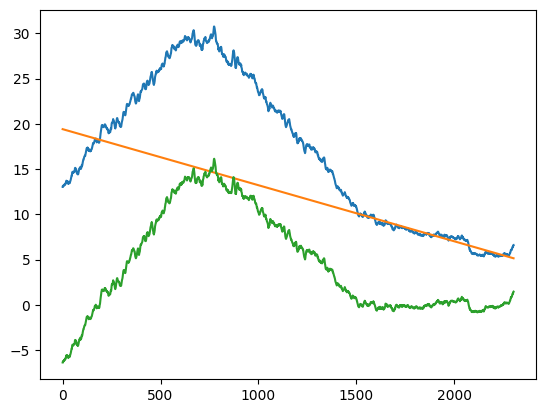

In [15]:
e_dist=df_camera_smooth.loc[300]
x=np.linspace(0,len(df_camera_smooth.columns)-1,len(df_camera_smooth.columns))
#fit the last 500 points
m,b = np.polyfit(x[-500:], e_dist[-500:], 1)
print(m,b)
fitting=m*x+b
plt.plot(x,e_dist)
plt.plot(fitting)
plt.plot(e_dist-fitting)

In [16]:
def rmv_mean(df_camera,lastpoints):
    x=np.linspace(0,len(df_camera.columns)-1,len(df_camera.columns))
    #get the coeficients for each shhot
    coef=df_camera.apply(lambda row: np.polyfit(x[-lastpoints:], row[-lastpoints:], 1),axis=1, result_type='expand').to_numpy()
    m=coef[:,0]
    b=coef[:,1]

    #build the aray with the fitting for every shot
    fit=[]
    for i in range(0,len(m)):
        fit.append(m[i]*x+b[i])
    df_fitting=pd.DataFrame(fit)

    df_adjusted=df_camera-df_fitting
    return df_adjusted

In [17]:
lastpoints=500
df_camera_adjusted=rmv_mean(df_camera_smooth,lastpoints)

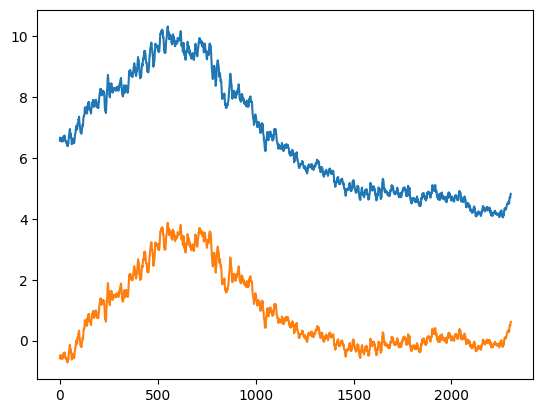

In [18]:
shot_index=140
#fitting=coef.iloc[shot_index][0]*x+coef.iloc[shot_index][1]
e_dist=df_camera_smooth.loc[shot_index]
e_dist_adj=df_camera_adjusted.loc[shot_index]
plt.plot(x,e_dist)
#plt.plot(fit[shot_index])
plt.plot(x,e_dist_adj)

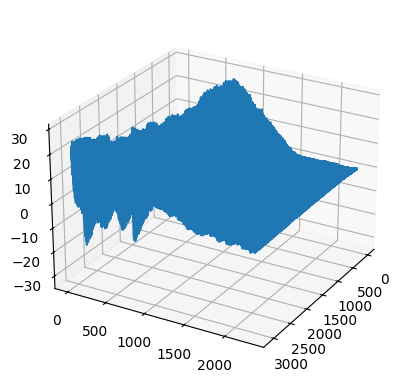

In [19]:
x=np.linspace(0,len(df_camera.columns)-1,len(df_camera.columns))
y=np.linspace(0,df_camera.shape[0]-1,df_camera.shape[0])
X, Y = np.meshgrid(x, y)

fig = plt.figure()
ax = fig.add_subplot(projection='3d')

ax.plot_wireframe(Y, X, df_camera_adjusted, rstride=10, cstride=10)

#ax = Axes3D(fig)
#surf = ax.plot_surface(Y, X, df_camera_adjusted)#, rstride=1, cstride=1, cmap=cm.coolwarm,
                       #linewidth=0, antialiased=False)

#ax.set_xlabel('x')
#ax.set_ylabel('y')
#ax.set_zlabel('E_dist')
ax.view_init(elev=25, azim=30)
#plt.title('Error vs order2 and order3')
plt.show()

### Look for the maximum

In [50]:
## Fit a curve to given (x,y) data
def fitting(x,y,p0):
    popt, pcov = curve_fit(func, x, y,p0,maxfev=1000)
    return popt

#define the curve to fit
def func(t,c0, c1,c2): 
    #return c0*np.log(c1)+c2*t
    #return c0*x**2+c1*x+c2
    return c0*np.exp(-((t-c1)**2)/(2*c2*c2))

#Look for max location using the fitting function (around the maximum value)
#Returns the 'pixel' location of the maximum
def find_max(e_dist):
    try:
        #x=np.linspace(0,len(e_dist)-1,len(e_dist))
        #redefine a shorter range around the max
        e_zoom=e_dist[int(0.5*np.argmax(e_dist)):int(1.5*np.argmax(e_dist))]
        x_zoom=np.linspace(int(0.5*np.argmax(e_dist)),int(1.5*np.argmax(e_dist))-1,len(e_zoom))
        p0=[np.max(e_dist),500,1]#initial guess
        popt=fitting(x_zoom,e_zoom,p0)
    except:
        print('Error in the find max')
        popt=[0,0,0]
    if(popt[1]>len(e_dist) or popt[1]<0):
        return 0 #could'nt find the max with this method
    else:
        return popt[1]
        
#Look for max location using the fitting function
#Returns the 'pixel' location of the maximum
def find_max_old(e_dist):
    try:
        #print(e_dist)
        x=np.linspace(0,len(e_dist)-1,len(e_dist))
        #print(len(e_dist)-1,e_dist[1])
        p0=[np.max(e_dist),500,1]#initial guess
        popt=fitting(x,e_dist,p0)
    except:
        print('Error in the find max')
        popt=[0,0,0]
    if(popt[1]>len(e_dist) or popt[1]<0):
        return 0 #could'nt find the max with this method
    else:
        return popt[1]

17.18940021530493
[ 16.04444321 744.49572507 315.2824795 ]


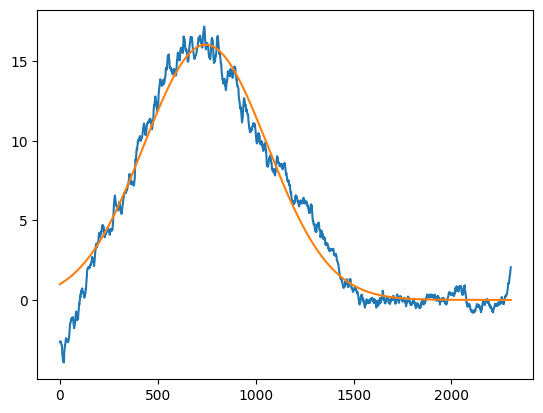

[15.97926125  1.30339402  0.79062205]


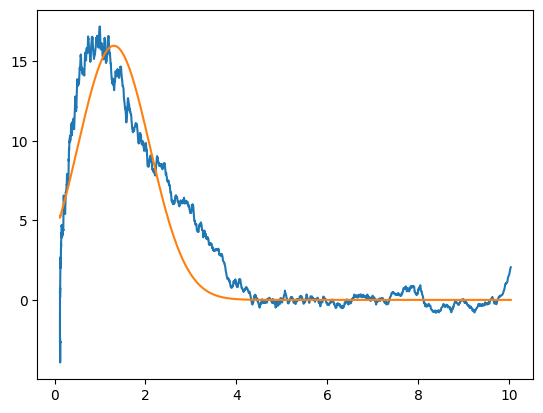

In [21]:
e_dist_adj=df_camera_adjusted.loc[801]
#x=np.linspace(0,len(df_camera_adjusted.columns)-1,len(df_camera_adjusted.columns))
x=np.linspace(0,len(e_dist_adj)-1,len(e_dist_adj))
x_ene=conv_energy(x)

print(np.max(e_dist_adj))
#fitting in the pixel domain
p0=[np.max(e_dist_adj),500,1]#initial guess
popt=fitting(x,e_dist_adj,p0)
print(popt)
y_fit=func(x,popt[0],popt[1],popt[2])
plt.plot(x,e_dist_adj)
plt.plot(x,y_fit)
plt.show()

#fitting in the energy domain
p0=[np.max(e_dist_adj),1,1]#initial guess
popt=fitting(x_ene,e_dist_adj,p0)
print(popt)
y_fit=func(x_ene,popt[0],popt[1],popt[2])
plt.plot(x_ene,e_dist_adj)
plt.plot(x_ene,y_fit)
plt.show()


17.18940021530493
368     7.448337
369     7.406952
370     7.396566
371     7.376681
372     7.397046
          ...   
1100    7.894275
1101    8.058640
1102    8.070755
1103    8.154869
1104    8.422484
Name: 801, Length: 737, dtype: float64
[ 16.07409009 715.2083923  310.16281814]


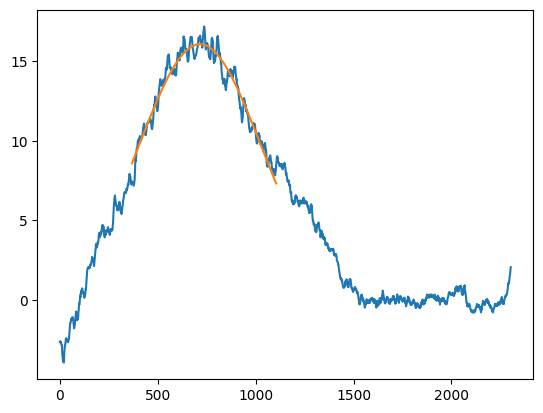

[15.84271604  1.06567076  0.85023438]


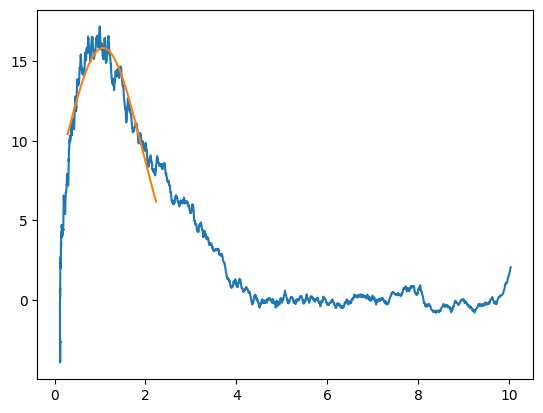

In [49]:
e_dist_adj=df_camera_adjusted.loc[801]
#x=np.linspace(0,len(df_camera_adjusted.columns)-1,len(df_camera_adjusted.columns))
x=np.linspace(0,len(e_dist_adj)-1,len(e_dist_adj))
x_ene=conv_energy(x)

print(np.max(e_dist_adj))
#fitting in the pixel domain
#just around the peak
e_zoom=e_dist_adj[int(0.5*np.argmax(e_dist_adj)):int(1.5*np.argmax(e_dist_adj))]
print(e_zoom)
x_zoom=np.linspace(int(0.5*np.argmax(e_dist_adj)),int(1.5*np.argmax(e_dist_adj))-1,len(e_zoom))

p0=[np.max(e_dist_adj),500,1]#initial guess
popt=fitting(x_zoom,e_zoom,p0)
print(popt)
y_fit=func(x_zoom,popt[0],popt[1],popt[2])
plt.plot(x,e_dist_adj)
plt.plot(x_zoom,y_fit)
plt.show()

#fitting in the energy domain
#around the peak
p0=[np.max(e_dist_adj),1,1]#initial guess
e_zoom=e_dist_adj[int(0.5*np.argmax(e_dist_adj)):int(1.5*np.argmax(e_dist_adj))]
x_ene_zoom=conv_energy(x_zoom)

popt=fitting(x_ene_zoom,e_zoom,p0)
print(popt)
y_fit=func(x_ene_zoom,popt[0],popt[1],popt[2])
plt.plot(x_ene,e_dist_adj)
plt.plot(x_ene_zoom,y_fit)
plt.show()

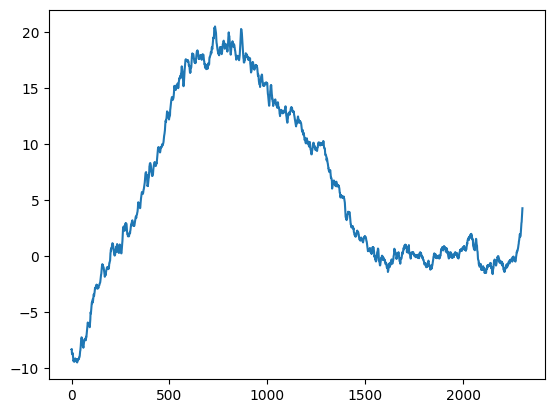

In [88]:
e_dist_examp=df_camera_adjusted.loc[1900]
find_max(e_dist_examp)
plt.plot(e_dist_examp)

### Cut-off point

In [24]:
#input a single shot (and the max location) and returns the position of the cut-off
def get_cutoff(df_camera_shot,maxpos):
    #The function look for the first zero value after the max value
    cutoff_poss=df_camera_shot[int(maxpos):][df_camera_shot<0].dropna().index[0]
    return cutoff_poss

In [25]:
#input a single shot and returns the position of the cut-off
#This will be SLOWER than the other approach
def get_cutoff_2(df_camera_shot):
    #The function look for the first zero value after the max value
    #1:Look for the max value
    maxpos=find_max(df_camera_shot)
    #print(maxpos,len(df_camera_shot))
    #2)
    cutoff_poss=df_camera_shot[int(maxpos):][df_camera_shot<0].dropna().index[0]
    return cutoff_poss

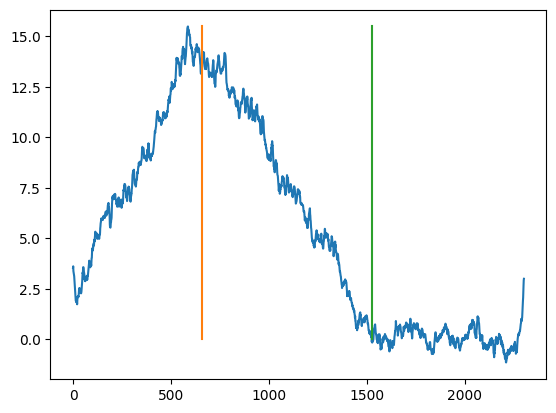

In [52]:
e_dist=df_camera_adjusted.loc[1410]
maxpos=find_max(e_dist)
cutoff_pos=get_cutoff(e_dist,maxpos)

yaux=np.linspace(0,np.max(e_dist),10)
xaux_max=0*yaux+maxpos
xaux_cutoff=0*yaux+cutoff_pos
plt.plot(e_dist)
plt.plot(xaux_max,yaux)
plt.plot(xaux_cutoff,yaux)

## Integration

In [209]:
def integr(e_dist):
    x=np.linspace(0,len(e_dist)-1,len(e_dist))
    #calculate the start(first positive) and end of integration(cut off)
    max_pos=find_max(e_dist)
    cutoff_pos=get_cutoff(e_dist,max_pos)  #end position
    start_pos=0
    for i in range(0,len(e_dist)):
        if (e_dist[i]>0):
            #print(i,e_dist[i])
            start_pos=i
            break
    e_dist_short=e_dist[start_pos:cutoff_pos]
    x_short=x[start_pos:cutoff_pos]
    
    #x=np.linspace(0,len(e_dist_short)-1,len(e_dist_short))
    x_ene=conv_energy(x_short)
    #return integrate.simpson(e_dist, x=x_ene)
    return integrate.trapezoid(e_dist_short, x=x_ene)

Integral: 18.018785711943103


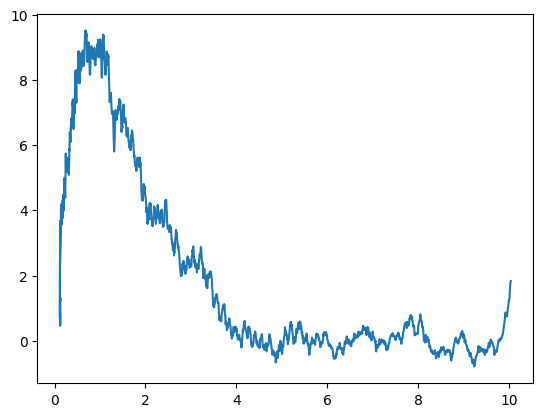

In [191]:
e_dist_adj=df_camera_adjusted.loc[775]

#integrate
print('Integral:',integr(e_dist_adj))
x=np.linspace(0,len(e_dist_adj)-1,len(e_dist_adj))
e_zoom=e_dist_adj[335:]
x_zoom=x[335:]
x_ene=conv_energy(x)
x_ene_zoom=conv_energy(x_zoom)
#plt.plot(x,e_dist_adj)
plt.plot(x_ene,e_dist_adj)


## Construct the dataframe with metrics

In [53]:
#df_metrics['Max E']=df_camera_adjusted.apply(lambda row: find_max(row))
#print(df_camera_adjusted)
df_metrics=pd.DataFrame()
df_metrics['Max E']=df_camera_adjusted.apply(find_max,axis=1)
#convert to Energy
df_metrics['Max E']=df_metrics['Max E'].apply(conv_energy)

/tmp/ipykernel_66274/2225689608.py:3: OptimizeWarning: Covariance of the parameters could not be estimated
  popt, pcov = curve_fit(func, x, y,p0,maxfev=1000)


Error in the find max
Error in the find max
Error in the find max
Error in the find max
Error in the find max
Error in the find max
Error in the find max
Error in the find max
Error in the find max
Error in the find max
Error in the find max
Error in the find max
Error in the find max
Error in the find max
Error in the find max
Error in the find max
Error in the find max
Error in the find max
Error in the find max
Error in the find max
Error in the find max
Error in the find max
Error in the find max
Error in the find max
Error in the find max
Error in the find max
Error in the find max
Error in the find max
Error in the find max
Error in the find max
Error in the find max
Error in the find max
Error in the find max
Error in the find max
Error in the find max
Error in the find max
Error in the find max
Error in the find max
Error in the find max
Error in the find max
Error in the find max
Error in the find max
Error in the find max
Error in the find max
Error in the find max
Error in t

In [54]:
#calculate hte cutoff energy
df_metrics['Cutoff E']=df_camera_adjusted.apply(get_cutoff_2,axis=1)
#convert to Energy
df_metrics['Cutoff E']=df_metrics['Cutoff E'].apply(conv_energy)

/tmp/ipykernel_66274/2225689608.py:3: OptimizeWarning: Covariance of the parameters could not be estimated
  popt, pcov = curve_fit(func, x, y,p0,maxfev=1000)
/tmp/ipykernel_66274/2225689608.py:3: OptimizeWarning: Covariance of the parameters could not be estimated
  popt, pcov = curve_fit(func, x, y,p0,maxfev=1000)


Error in the find max
Error in the find max
Error in the find max
Error in the find max
Error in the find max
Error in the find max


/tmp/ipykernel_66274/2225689608.py:3: OptimizeWarning: Covariance of the parameters could not be estimated
  popt, pcov = curve_fit(func, x, y,p0,maxfev=1000)
/tmp/ipykernel_66274/2225689608.py:3: OptimizeWarning: Covariance of the parameters could not be estimated
  popt, pcov = curve_fit(func, x, y,p0,maxfev=1000)
/tmp/ipykernel_66274/2225689608.py:3: OptimizeWarning: Covariance of the parameters could not be estimated
  popt, pcov = curve_fit(func, x, y,p0,maxfev=1000)
/tmp/ipykernel_66274/2225689608.py:3: OptimizeWarning: Covariance of the parameters could not be estimated
  popt, pcov = curve_fit(func, x, y,p0,maxfev=1000)


Error in the find max
Error in the find max
Error in the find max
Error in the find max
Error in the find max
Error in the find max
Error in the find max
Error in the find max
Error in the find max
Error in the find max
Error in the find max
Error in the find max
Error in the find max
Error in the find max
Error in the find max
Error in the find max
Error in the find max
Error in the find max
Error in the find max
Error in the find max
Error in the find max
Error in the find max
Error in the find max
Error in the find max
Error in the find max
Error in the find max
Error in the find max
Error in the find max
Error in the find max
Error in the find max
Error in the find max
Error in the find max
Error in the find max
Error in the find max


/tmp/ipykernel_66274/2225689608.py:3: OptimizeWarning: Covariance of the parameters could not be estimated
  popt, pcov = curve_fit(func, x, y,p0,maxfev=1000)
/tmp/ipykernel_66274/2225689608.py:3: OptimizeWarning: Covariance of the parameters could not be estimated
  popt, pcov = curve_fit(func, x, y,p0,maxfev=1000)
/tmp/ipykernel_66274/2225689608.py:3: OptimizeWarning: Covariance of the parameters could not be estimated
  popt, pcov = curve_fit(func, x, y,p0,maxfev=1000)


Error in the find max
Error in the find max
Error in the find max
Error in the find max
Error in the find max
Error in the find max
Error in the find max
Error in the find max
Error in the find max
Error in the find max
Error in the find max
Error in the find max
Error in the find max
Error in the find max
Error in the find max
Error in the find max
Error in the find max
Error in the find max
Error in the find max
Error in the find max
Error in the find max
Error in the find max
Error in the find max
Error in the find max
Error in the find max
Error in the find max
Error in the find max
Error in the find max
Error in the find max
Error in the find max
Error in the find max
Error in the find max
Error in the find max
Error in the find max
Error in the find max
Error in the find max
Error in the find max
Error in the find max
Error in the find max
Error in the find max
Error in the find max
Error in the find max
Error in the find max
Error in the find max
Error in the find max
Error in t

/tmp/ipykernel_66274/2225689608.py:3: OptimizeWarning: Covariance of the parameters could not be estimated
  popt, pcov = curve_fit(func, x, y,p0,maxfev=1000)


Error in the find max
Error in the find max
Error in the find max
Error in the find max
Error in the find max
Error in the find max
Error in the find max
Error in the find max
Error in the find max
Error in the find max
Error in the find max
Error in the find max
Error in the find max
Error in the find max
Error in the find max
Error in the find max
Error in the find max
Error in the find max
Error in the find max
Error in the find max
Error in the find max
Error in the find max
Error in the find max
Error in the find max
Error in the find max
Error in the find max
Error in the find max
Error in the find max
Error in the find max
Error in the find max
Error in the find max
Error in the find max
Error in the find max
Error in the find max
Error in the find max
Error in the find max
Error in the find max
Error in the find max
Error in the find max
Error in the find max
Error in the find max
Error in the find max
Error in the find max
Error in the find max
Error in the find max
Error in t

In [210]:
#calculate the integral
df_metrics['Integr']=df_camera_adjusted.apply(integr,axis=1)

/tmp/ipykernel_66274/2225689608.py:3: OptimizeWarning: Covariance of the parameters could not be estimated
  popt, pcov = curve_fit(func, x, y,p0,maxfev=1000)
/tmp/ipykernel_66274/2225689608.py:3: OptimizeWarning: Covariance of the parameters could not be estimated
  popt, pcov = curve_fit(func, x, y,p0,maxfev=1000)


Error in the find max
Error in the find max
Error in the find max
Error in the find max
Error in the find max


/tmp/ipykernel_66274/2225689608.py:3: OptimizeWarning: Covariance of the parameters could not be estimated
  popt, pcov = curve_fit(func, x, y,p0,maxfev=1000)
/tmp/ipykernel_66274/2225689608.py:3: OptimizeWarning: Covariance of the parameters could not be estimated
  popt, pcov = curve_fit(func, x, y,p0,maxfev=1000)
/tmp/ipykernel_66274/2225689608.py:3: OptimizeWarning: Covariance of the parameters could not be estimated
  popt, pcov = curve_fit(func, x, y,p0,maxfev=1000)


Error in the find max


/tmp/ipykernel_66274/2225689608.py:3: OptimizeWarning: Covariance of the parameters could not be estimated
  popt, pcov = curve_fit(func, x, y,p0,maxfev=1000)


Error in the find max
Error in the find max
Error in the find max
Error in the find max
Error in the find max
Error in the find max
Error in the find max
Error in the find max
Error in the find max
Error in the find max
Error in the find max
Error in the find max
Error in the find max
Error in the find max
Error in the find max
Error in the find max
Error in the find max
Error in the find max
Error in the find max
Error in the find max
Error in the find max
Error in the find max
Error in the find max
Error in the find max
Error in the find max
Error in the find max
Error in the find max
Error in the find max
Error in the find max
Error in the find max
Error in the find max
Error in the find max


/tmp/ipykernel_66274/2225689608.py:3: OptimizeWarning: Covariance of the parameters could not be estimated
  popt, pcov = curve_fit(func, x, y,p0,maxfev=1000)
/tmp/ipykernel_66274/2225689608.py:3: OptimizeWarning: Covariance of the parameters could not be estimated
  popt, pcov = curve_fit(func, x, y,p0,maxfev=1000)
/tmp/ipykernel_66274/2225689608.py:3: OptimizeWarning: Covariance of the parameters could not be estimated
  popt, pcov = curve_fit(func, x, y,p0,maxfev=1000)


Error in the find max
Error in the find max
Error in the find max
Error in the find max
Error in the find max
Error in the find max
Error in the find max
Error in the find max
Error in the find max
Error in the find max
Error in the find max
Error in the find max
Error in the find max
Error in the find max
Error in the find max
Error in the find max
Error in the find max
Error in the find max
Error in the find max
Error in the find max
Error in the find max
Error in the find max
Error in the find max
Error in the find max
Error in the find max
Error in the find max
Error in the find max
Error in the find max
Error in the find max
Error in the find max
Error in the find max
Error in the find max
Error in the find max
Error in the find max
Error in the find max
Error in the find max
Error in the find max
Error in the find max
Error in the find max
Error in the find max
Error in the find max
Error in the find max
Error in the find max
Error in the find max


/tmp/ipykernel_66274/2225689608.py:3: OptimizeWarning: Covariance of the parameters could not be estimated
  popt, pcov = curve_fit(func, x, y,p0,maxfev=1000)


Error in the find max
Error in the find max
Error in the find max
Error in the find max
Error in the find max
Error in the find max
Error in the find max
Error in the find max
Error in the find max
Error in the find max
Error in the find max
Error in the find max
Error in the find max
Error in the find max
Error in the find max
Error in the find max
Error in the find max
Error in the find max
Error in the find max
Error in the find max
Error in the find max
Error in the find max
Error in the find max
Error in the find max
Error in the find max
Error in the find max
Error in the find max
Error in the find max
Error in the find max
Error in the find max
Error in the find max
Error in the find max
Error in the find max
Error in the find max
Error in the find max
Error in the find max
Error in the find max
Error in the find max
Error in the find max
Error in the find max
Error in the find max
Error in the find max
Error in the find max
Error in the find max
Error in the find max
Error in t

Text(0, 0.5, 'Num. shots')

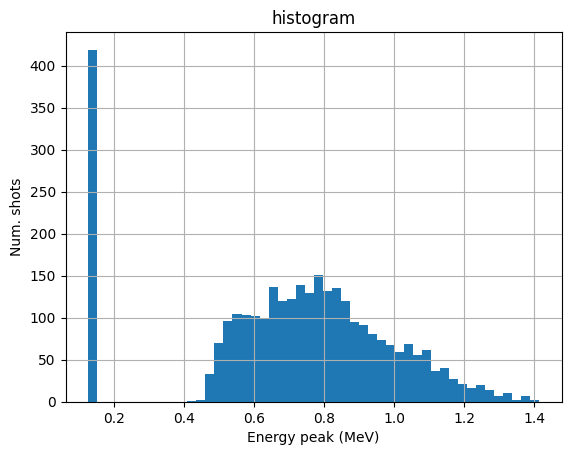

In [197]:
df_metrics['Max E'].hist(bins=50)
plt.title('histogram')
plt.xlabel('Energy peak (MeV)')
plt.ylabel('Num. shots')

Text(0, 0.5, 'Num. shots')

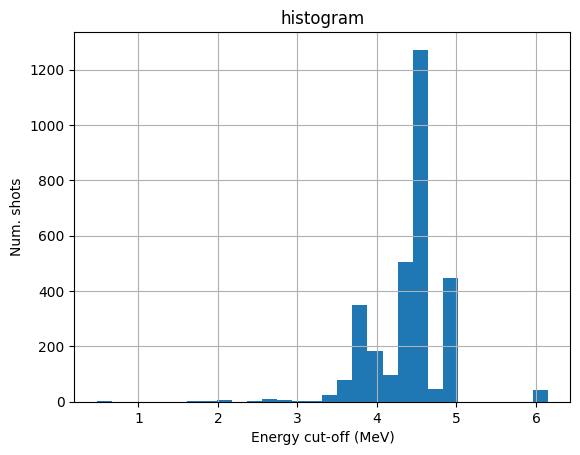

In [30]:
df_metrics['Cutoff E'].hist(bins=30)
plt.title('histogram')
plt.xlabel('Energy cut-off (MeV)')
plt.ylabel('Num. shots')

Text(0, 0.5, 'Num. shots')

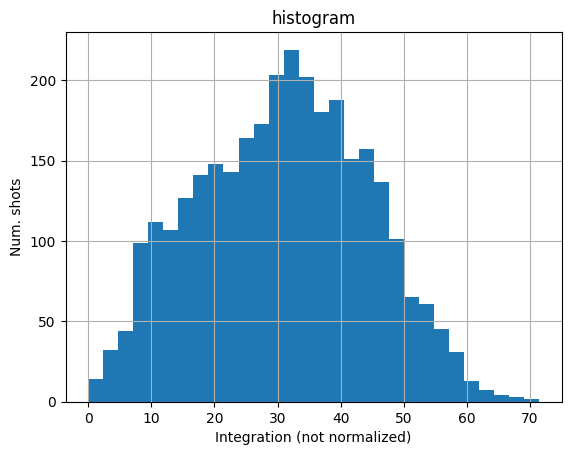

In [211]:
df_metrics['Integr'].hist(bins=30)
plt.title('histogram')
plt.xlabel('Integration (not normalized)')
plt.ylabel('Num. shots')

## Drop te shots with wrong max E

In [212]:
df_metrics_reduced=df_metrics[df_metrics['Max E']>0.2]

In [213]:
good_shots_list=df_metrics_reduced.index.values
#print(good_shots_list)
df_input_reduced=df_input.iloc[good_shots_list]

#reset the index
df_metrics_reduced.reset_index(inplace=True,drop=True)
df_input_reduced.reset_index(inplace=True,drop=True)

In [214]:
df_input_reduced

,shot number,order2,order3,order4
0,152354,34900.0,-17000.0,-4600000.0
1,152355,34900.0,-17000.0,-4600000.0
2,152356,34900.0,-17000.0,-4600000.0
3,152357,34900.0,-17000.0,-4600000.0
4,152358,34900.0,-17000.0,-4600000.0
...,...,...,...,...
2649,155420,35400.0,28000.0,-3700000.0
2650,155421,35400.0,28000.0,-3700000.0
2651,155422,35400.0,28000.0,-3700000.0
2652,155424,35400.0,28000.0,-3700000.0


Text(0, 0.5, 'Num. shots')

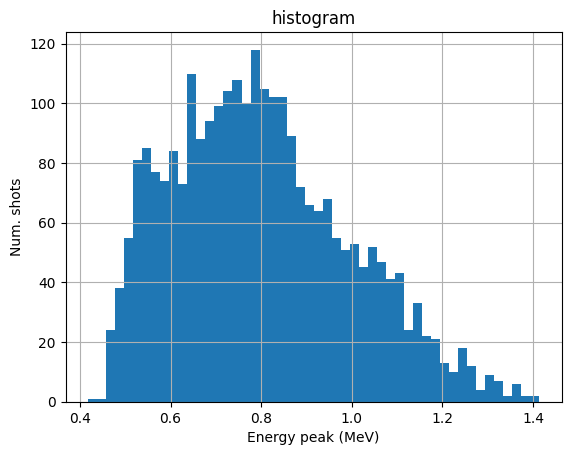

In [215]:
df_metrics_reduced['Max E'].hist(bins=50)
plt.title('histogram')
plt.xlabel('Energy peak (MeV)')
plt.ylabel('Num. shots')

## Distribution in the parameter space

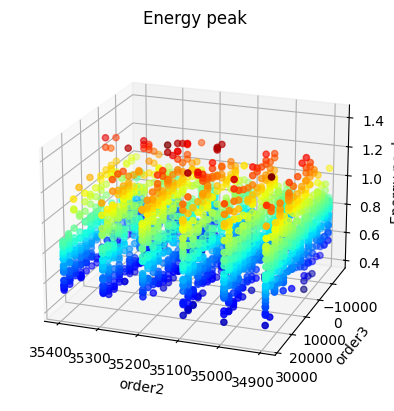

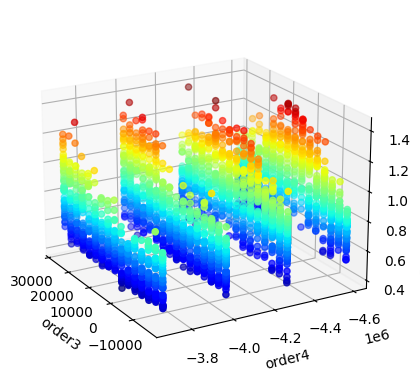

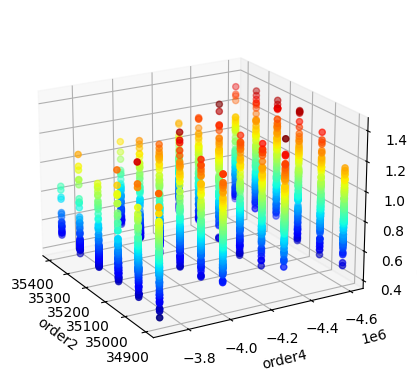

In [102]:
fig = plt.figure()
ax = fig.add_subplot(projection='3d')
ax.scatter(df_input_reduced['order2'], df_input_reduced['order3'], df_metrics_reduced['Max E'],c=df_metrics_reduced['Max E'],cmap='jet')
ax.set_xlabel('order2')
ax.set_ylabel('order3')
ax.set_zlabel('Energy peak')
#zticks = [1e-8, 1e-7, 1e-6, 1e-5, 1e-4, 1e-3]
#ax.set_zticks(np.log10(zticks))
#print(df_error)
#ax.set_zscale('log')
ax.view_init(elev=20., azim=110)
plt.title('Energy peak')
plt.show()

fig = plt.figure()
ax2 = fig.add_subplot(projection='3d')
ax2.scatter(df_input_reduced['order3'], df_input_reduced['order4'], df_metrics_reduced['Max E'],c=df_metrics_reduced['Max E'],cmap='jet')
ax2.set_xlabel('order3')
ax2.set_ylabel('order4')
ax2.set_zlabel('Energy peak (MeV)')
#ax2.set_zscale('log')
ax2.view_init(elev=20., azim=150)
#plt.title('error vs order3 and order4')
plt.show()

fig = plt.figure()
ax3 = fig.add_subplot(projection='3d')
ax3.scatter(df_input_reduced['order2'], df_input_reduced['order4'], df_metrics_reduced['Max E'],c=df_metrics_reduced['Max E'],cmap='jet')
ax3.set_xlabel('order2')
ax3.set_ylabel('order4')
ax3.set_zlabel('Energy peak (MeV)')
#ax2.set_zscale('log')
ax3.view_init(elev=20., azim=150)
#plt.title('error vs order3 and order4')
plt.show()

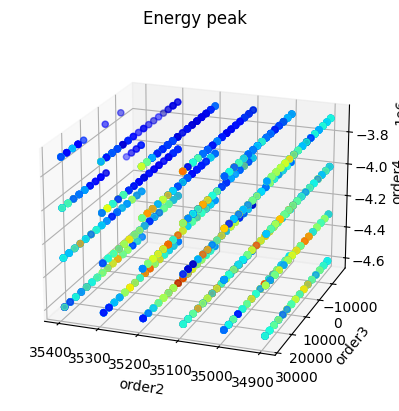

In [103]:
fig = plt.figure()
ax = fig.add_subplot(projection='3d')
ax.scatter(df_input_reduced['order2'], df_input_reduced['order3'], df_input_reduced['order4'],c=df_metrics_reduced['Max E'],cmap='jet')
ax.set_xlabel('order2')
ax.set_ylabel('order3')
ax.set_zlabel('order4')
#zticks = [1e-8, 1e-7, 1e-6, 1e-5, 1e-4, 1e-3]
#ax.set_zticks(np.log10(zticks))
#print(df_error)
#ax.set_zscale('log')
ax.view_init(elev=20., azim=110)
plt.title('Energy peak')
plt.show()

### Cut-off dist

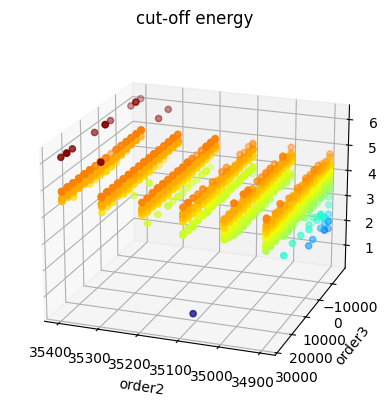

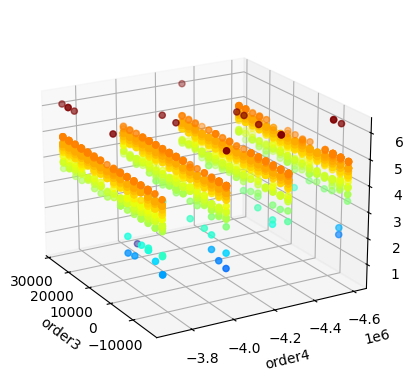

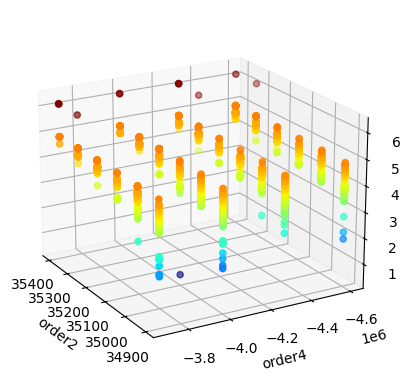

In [104]:
fig = plt.figure()
ax = fig.add_subplot(projection='3d')
ax.scatter(df_input_reduced['order2'], df_input_reduced['order3'], df_metrics_reduced['Cutoff E'],c=df_metrics_reduced['Cutoff E'],cmap='jet')
ax.set_xlabel('order2')
ax.set_ylabel('order3')
ax.set_zlabel('Cut-offEnergy')
#zticks = [1e-8, 1e-7, 1e-6, 1e-5, 1e-4, 1e-3]
#ax.set_zticks(np.log10(zticks))
#print(df_error)
#ax.set_zscale('log')
ax.view_init(elev=20., azim=110)
plt.title('cut-off energy')
plt.show()

fig = plt.figure()
ax2 = fig.add_subplot(projection='3d')
ax2.scatter(df_input_reduced['order3'], df_input_reduced['order4'], df_metrics_reduced['Cutoff E'],c=df_metrics_reduced['Cutoff E'],cmap='jet')
ax2.set_xlabel('order3')
ax2.set_ylabel('order4')
ax2.set_zlabel('Cut-off Energy(MeV)')
#ax2.set_zscale('log')
ax2.view_init(elev=20., azim=150)
#plt.title('error vs order3 and order4')
plt.show()

fig = plt.figure()
ax3 = fig.add_subplot(projection='3d')
ax3.scatter(df_input_reduced['order2'], df_input_reduced['order4'], df_metrics_reduced['Cutoff E'],c=df_metrics_reduced['Cutoff E'],cmap='jet')
ax3.set_xlabel('order2')
ax3.set_ylabel('order4')
ax3.set_zlabel('Cut-off Energy (MeV)')
#ax2.set_zscale('log')
ax3.view_init(elev=20., azim=150)
#plt.title('error vs order3 and order4')
plt.show()

         Max E  Cutoff E
1458  0.479039  0.478202


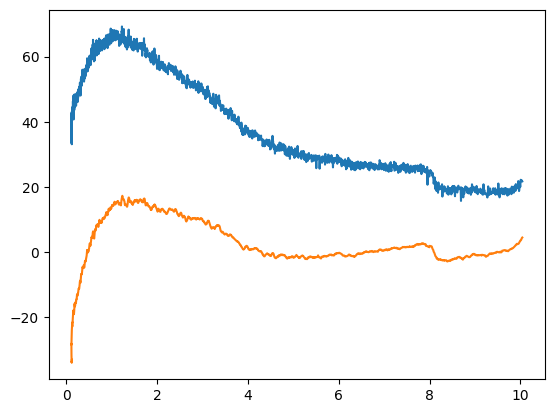

In [105]:
print(df_metrics[df_metrics['Cutoff E']<1])
e_dist=df_camera.loc[1458]
e_dist2=df_camera_adjusted.loc[1458]
x=np.linspace(0,len(e_dist)-1,len(e_dist))
MeV = 0.000002*x**2 - 0.0003 * x + .1265
plt.plot(MeV,e_dist)
plt.plot(MeV,e_dist2)

In [35]:
print(df_metrics[df_metrics['Cutoff E']>6])

         Max E  Cutoff E
2116  0.625015  6.149588
2185  0.790996  6.087218
2559  0.641516  6.128762
2577  0.623447  6.128762
2591  0.126500  6.135700
2597  0.714153  6.135700
2602  0.658455  6.135700
2605  0.646228  6.135700
2621  0.126500  6.135700
2628  0.670481  6.128762
2649  0.126500  6.135700
2651  0.126500  6.149588
2684  0.126500  6.149588
2709  0.126500  6.135700
2718  0.126500  6.135700
2767  0.580666  6.142642
2770  0.126500  6.135700
2771  0.126500  6.135700
2772  0.126500  6.135700
2776  0.126500  6.142642
2779  0.126500  6.135700
2783  0.126500  6.135700
2799  0.587086  6.135700
2801  0.545491  6.135700
2802  0.126500  6.142642
2805  0.126500  6.142642
2809  0.557457  6.135700
2833  0.126500  6.128762
2843  0.126500  6.135700
2845  0.126500  6.142642
2846  0.126500  6.142642
2865  0.552614  6.135700
2877  0.126500  6.142642
2879  0.126500  6.135700
2880  0.126500  6.135700
2908  0.126500  6.142642
2911  0.126500  6.142642
3008  0.736524  6.135700
3034  0.591662  6.135700


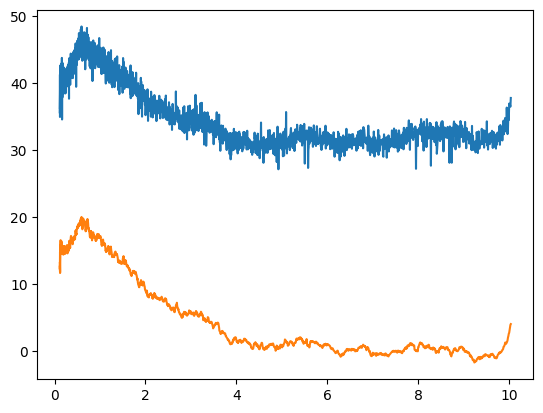

In [36]:
e_dist=df_camera.loc[2116]
e_dist2=df_camera_adjusted.loc[2116]
x=np.linspace(0,len(e_dist)-1,len(e_dist))
MeV = 0.000002*x**2 - 0.0003 * x + .1265
plt.plot(MeV,e_dist)
plt.plot(MeV,e_dist2)

## Study shot variability

In [195]:
def shot_average(df_input,df_metrics):
    emax_list=[]
    ecut_list=[]
    integ_list=[]
    o2_list=[]
    o3_list=[]
    o4_list=[]
    emax_mean=[]
    emax_std=[]
    ecut_mean=[]
    ecut_std=[]
    integ_mean=[]
    integ_std=[]
    counter=0
    for index,row in df_input.iterrows():
        o2=row['order2']
        o3=row['order3']
        o4=row['order4']
        #print(index)
        if(index==0):
            emax_list.append(df_metrics['Max E'].iloc[index])
            ecut_list.append(df_metrics['Cutoff E'].iloc[index])
            integ_list.append(df_metrics['Integr'].iloc[index])
            counter=1
        if(index>0):
            o2_prev=df_input['order2'].iloc[index-1]
            o3_prev=df_input['order3'].iloc[index-1]
            o4_prev=df_input['order4'].iloc[index-1]
            if(o2==o2_prev and o3==o3_prev and o4==o4_prev):
                counter+=1
                emax_list.append(df_metrics['Max E'].iloc[index])
                ecut_list.append(df_metrics['Cutoff E'].iloc[index])
                integ_list.append(df_metrics['Integr'].iloc[index])
            else:
                #do the calc
                emax_mean.append(np.mean(emax_list))
                emax_std.append(np.std(emax_list))
                ecut_mean.append(np.mean(ecut_list))
                ecut_std.append(np.std(ecut_list))
                integ_mean.append(np.mean(integ_list))
                integ_std.append(np.std(integ_list))
                o2_list.append(o2_prev)
                o3_list.append(o3_prev)
                o4_list.append(o4_prev)
                #start the new batch
                emax_list=[df_metrics['Max E'].iloc[index]]
                ecut_list=[df_metrics['Cutoff E'].iloc[index]]
                integ_list=[df_metrics['Integr'].iloc[index]]
                #print(counter)
                counter=1
            #print(counter)

    df_metrics_avg=pd.DataFrame()
    df_metrics_avg['order2']=o2_list
    df_metrics_avg['order3']=o3_list
    df_metrics_avg['order4']=o4_list
    df_metrics_avg['Emax mean']=emax_mean
    df_metrics_avg['Emax std']=emax_std
    df_metrics_avg['Ecut mean']=ecut_mean
    df_metrics_avg['Ecut std']=ecut_std
    df_metrics_avg['Integr mean']=integ_mean
    df_metrics_avg['Integr std']=integ_std
    return df_metrics_avg

In [201]:
df_metrics_avg=shot_average(df_input_reduced,df_metrics_reduced)

In [202]:
df_metrics_avg

,order2,order3,order4,Emax mean,Emax std,Ecut mean,Ecut std,Integr mean,Integr std
0,34900.0,-17000.0,-4600000.0,0.763878,0.050358,3.936200,0.330107,15.730907,8.847814
1,34900.0,-17000.0,-4300000.0,0.808658,0.129553,4.135092,0.552447,20.780932,13.725833
2,34900.0,-17000.0,-4000000.0,0.736438,0.084330,3.436152,0.839525,11.917441,9.740162
3,34900.0,-17000.0,-3700000.0,0.732082,0.106619,3.297483,0.810176,8.573905,6.005852
4,34900.0,-14000.0,-4600000.0,0.746858,0.096383,3.535957,0.893276,10.992812,6.960163
...,...,...,...,...,...,...,...,...,...
366,35400.0,25000.0,-4000000.0,0.801709,0.066428,4.634609,0.094357,50.419644,4.444237
367,35400.0,25000.0,-3700000.0,0.579197,0.034161,5.498422,0.633814,49.830746,4.163163
368,35400.0,28000.0,-4600000.0,0.647472,0.112949,4.774606,0.144047,49.699932,4.675940
369,35400.0,28000.0,-4300000.0,0.714532,0.094015,4.839925,0.539425,49.083660,5.672972


Text(0, 0.5, 'Num. diff shots')

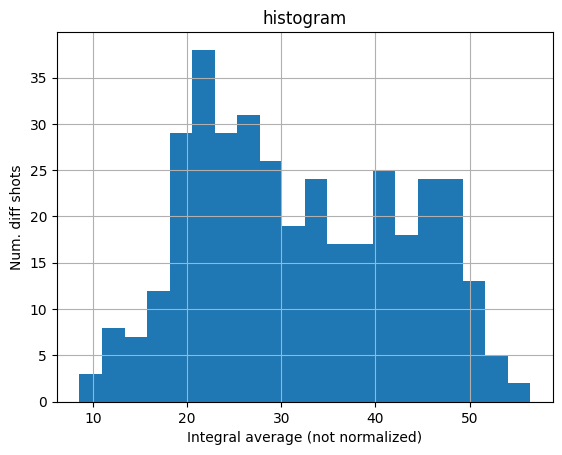

In [203]:
df_metrics_avg['Integr mean'].hist(bins=20)
plt.title('histogram')
plt.xlabel('Integral average (not normalized)')
plt.ylabel('Num. diff shots')

Text(0, 0.5, 'Num. diff shots')

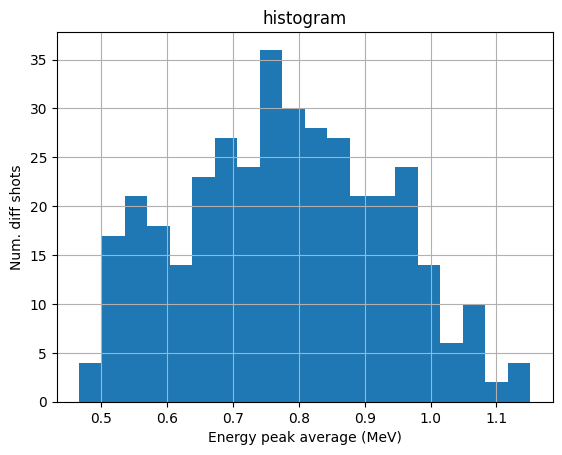

In [126]:
df_metrics_avg['Emax mean'].hist(bins=20)
plt.title('histogram')
plt.xlabel('Energy peak average (MeV)')
plt.ylabel('Num. diff shots')

Text(0, 0.5, 'Num. diff shots')

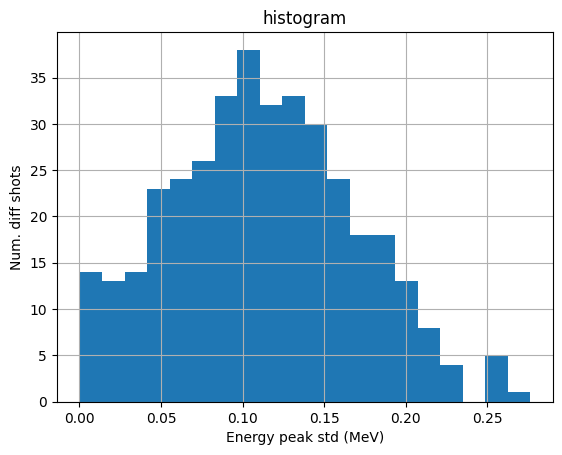

In [127]:
df_metrics_avg['Emax std'].hist(bins=20)
plt.title('histogram')
plt.xlabel('Energy peak std (MeV)')
plt.ylabel('Num. diff shots')

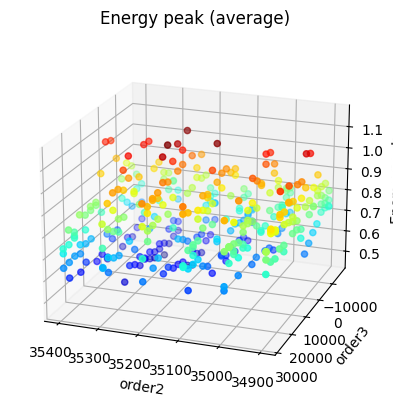

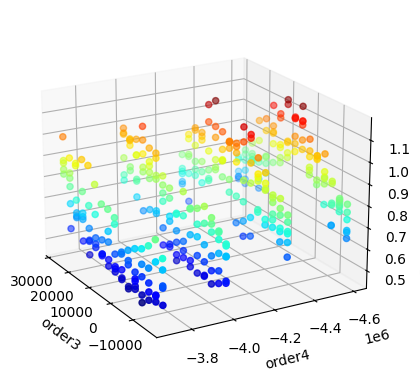

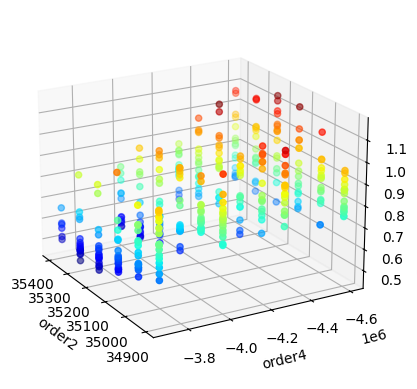

In [128]:
fig = plt.figure()
ax = fig.add_subplot(projection='3d')
ax.scatter(df_metrics_avg['order2'], df_metrics_avg['order3'], df_metrics_avg['Emax mean'],c=df_metrics_avg['Emax mean'],cmap='jet')
ax.set_xlabel('order2')
ax.set_ylabel('order3')
ax.set_zlabel('Energy peak')
#zticks = [1e-8, 1e-7, 1e-6, 1e-5, 1e-4, 1e-3]
#ax.set_zticks(np.log10(zticks))
#print(df_error)
#ax.set_zscale('log')
ax.view_init(elev=20., azim=110)
plt.title('Energy peak (average)')
plt.show()

fig = plt.figure()
ax2 = fig.add_subplot(projection='3d')
ax2.scatter(df_metrics_avg['order3'], df_metrics_avg['order4'], df_metrics_avg['Emax mean'],c=df_metrics_avg['Emax mean'],cmap='jet')
ax2.set_xlabel('order3')
ax2.set_ylabel('order4')
ax2.set_zlabel('Energy peak (MeV)')
#ax2.set_zscale('log')
ax2.view_init(elev=20., azim=150)
#plt.title('error vs order3 and order4')
plt.show()

fig = plt.figure()
ax3 = fig.add_subplot(projection='3d')
ax3.scatter(df_metrics_avg['order2'], df_metrics_avg['order4'], df_metrics_avg['Emax mean'],c=df_metrics_avg['Emax mean'],cmap='jet')
ax3.set_xlabel('order2')
ax3.set_ylabel('order4')
ax3.set_zlabel('Energy peak (MeV)')
#ax2.set_zscale('log')
ax3.view_init(elev=20., azim=150)
#plt.title('error vs order3 and order4')
plt.show()

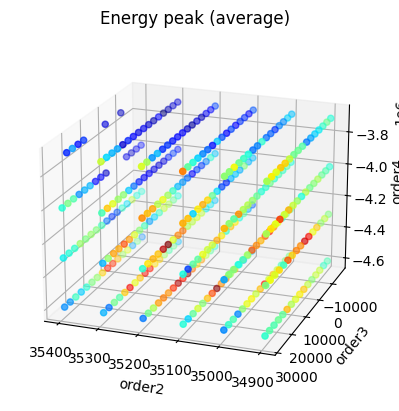

In [129]:
fig = plt.figure()
ax = fig.add_subplot(projection='3d')
ax.scatter(df_metrics_avg['order2'], df_metrics_avg['order3'], df_metrics_avg['order4'],c=df_metrics_avg['Emax mean'],cmap='jet')
ax.set_xlabel('order2')
ax.set_ylabel('order3')
ax.set_zlabel('order4')
#zticks = [1e-8, 1e-7, 1e-6, 1e-5, 1e-4, 1e-3]
#ax.set_zticks(np.log10(zticks))
#print(df_error)
#ax.set_zscale('log')
ax.view_init(elev=20., azim=110)
plt.title('Energy peak (average)')
plt.show()

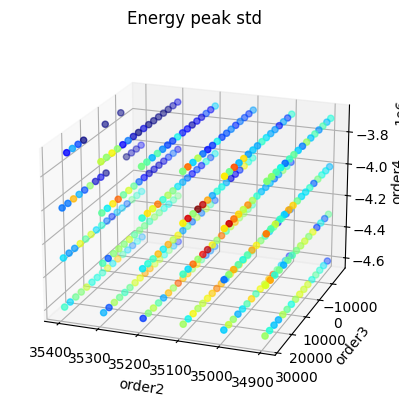

In [130]:
fig = plt.figure()
ax = fig.add_subplot(projection='3d')
ax.scatter(df_metrics_avg['order2'], df_metrics_avg['order3'], df_metrics_avg['order4'],c=df_metrics_avg['Emax std'],cmap='jet')
ax.set_xlabel('order2')
ax.set_ylabel('order3')
ax.set_zlabel('order4')
#zticks = [1e-8, 1e-7, 1e-6, 1e-5, 1e-4, 1e-3]
#ax.set_zticks(np.log10(zticks))
#print(df_error)
#ax.set_zscale('log')
ax.view_init(elev=20., azim=110)
plt.title('Energy peak std')
plt.show()

### cut-off average

Text(0, 0.5, 'Num. diff shots')

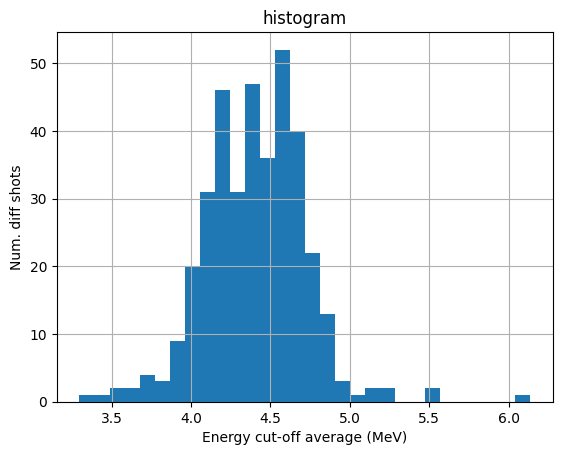

In [131]:
df_metrics_avg['Ecut mean'].hist(bins=30)
plt.title('histogram')
plt.xlabel('Energy cut-off average (MeV)')
plt.ylabel('Num. diff shots')

Text(0, 0.5, 'Num. diff shots')

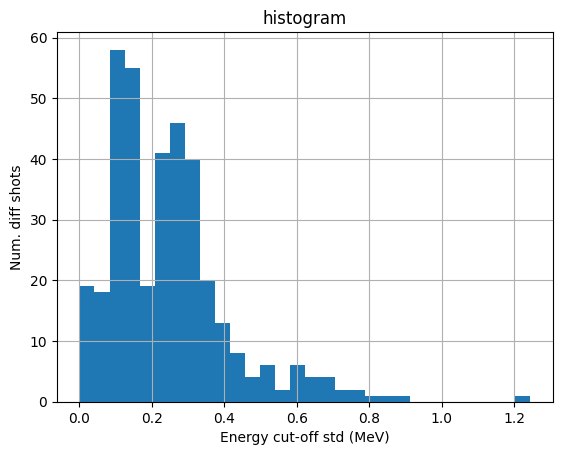

In [132]:
df_metrics_avg['Ecut std'].hist(bins=30)
plt.title('histogram')
plt.xlabel('Energy cut-off std (MeV)')
plt.ylabel('Num. diff shots')

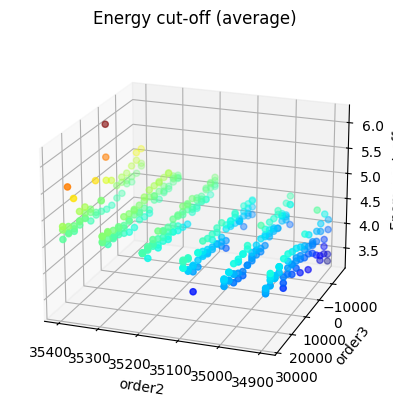

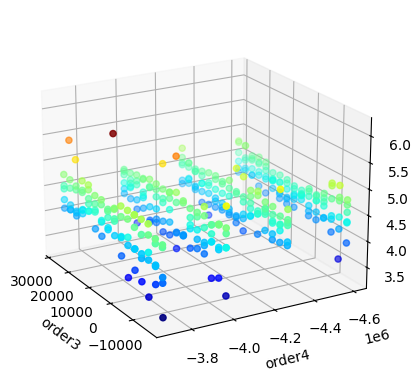

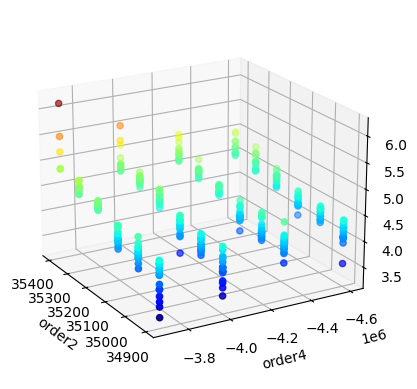

In [133]:
fig = plt.figure()
ax = fig.add_subplot(projection='3d')
ax.scatter(df_metrics_avg['order2'], df_metrics_avg['order3'], df_metrics_avg['Ecut mean'],c=df_metrics_avg['Ecut mean'],cmap='jet')
ax.set_xlabel('order2')
ax.set_ylabel('order3')
ax.set_zlabel('Energy cut-off')
#zticks = [1e-8, 1e-7, 1e-6, 1e-5, 1e-4, 1e-3]
#ax.set_zticks(np.log10(zticks))
#print(df_error)
#ax.set_zscale('log')
ax.view_init(elev=20., azim=110)
plt.title('Energy cut-off (average)')
plt.show()

fig = plt.figure()
ax2 = fig.add_subplot(projection='3d')
ax2.scatter(df_metrics_avg['order3'], df_metrics_avg['order4'], df_metrics_avg['Ecut mean'],c=df_metrics_avg['Ecut mean'],cmap='jet')
ax2.set_xlabel('order3')
ax2.set_ylabel('order4')
ax2.set_zlabel('Energy (MeV)')
#ax2.set_zscale('log')
ax2.view_init(elev=20., azim=150)
#plt.title('error vs order3 and order4')
plt.show()

fig = plt.figure()
ax3 = fig.add_subplot(projection='3d')
ax3.scatter(df_metrics_avg['order2'], df_metrics_avg['order4'], df_metrics_avg['Ecut mean'],c=df_metrics_avg['Ecut mean'],cmap='jet')
ax3.set_xlabel('order2')
ax3.set_ylabel('order4')
ax3.set_zlabel('Energy (MeV)')
#ax2.set_zscale('log')
ax3.view_init(elev=20., azim=150)
#plt.title('error vs order3 and order4')
plt.show()

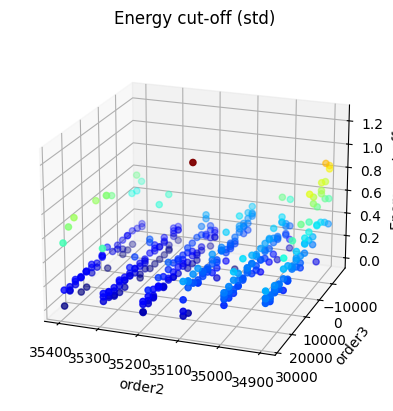

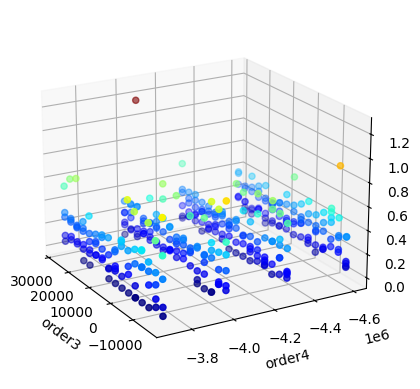

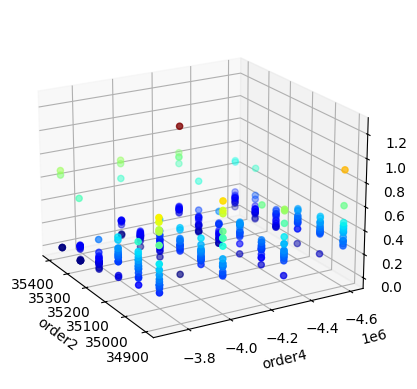

In [134]:
fig = plt.figure()
ax = fig.add_subplot(projection='3d')
ax.scatter(df_metrics_avg['order2'], df_metrics_avg['order3'], df_metrics_avg['Ecut std'],c=df_metrics_avg['Ecut std'],cmap='jet')
ax.set_xlabel('order2')
ax.set_ylabel('order3')
ax.set_zlabel('Energy cut-off')
#zticks = [1e-8, 1e-7, 1e-6, 1e-5, 1e-4, 1e-3]
#ax.set_zticks(np.log10(zticks))
#print(df_error)
#ax.set_zscale('log')
ax.view_init(elev=20., azim=110)
plt.title('Energy cut-off (std)')
plt.show()

fig = plt.figure()
ax2 = fig.add_subplot(projection='3d')
ax2.scatter(df_metrics_avg['order3'], df_metrics_avg['order4'], df_metrics_avg['Ecut std'],c=df_metrics_avg['Ecut std'],cmap='jet')
ax2.set_xlabel('order3')
ax2.set_ylabel('order4')
ax2.set_zlabel('Energy (MeV)')
#ax2.set_zscale('log')
ax2.view_init(elev=20., azim=150)
#plt.title('error vs order3 and order4')
plt.show()

fig = plt.figure()
ax3 = fig.add_subplot(projection='3d')
ax3.scatter(df_metrics_avg['order2'], df_metrics_avg['order4'], df_metrics_avg['Ecut std'],c=df_metrics_avg['Ecut std'],cmap='jet')
ax3.set_xlabel('order2')
ax3.set_ylabel('order4')
ax3.set_zlabel('Energy (MeV)')
#ax2.set_zscale('log')
ax3.view_init(elev=20., azim=150)
#plt.title('error vs order3 and order4')
plt.show()

# GOOD Performers

In [216]:
df_good_perf=df_metrics_avg[df_metrics_avg['Emax mean']>0.8]
#print(df_good_perf)

In [217]:
df_good_perf

,order2,order3,order4,Emax mean,Emax std,Ecut mean,Ecut std,Integr mean,Integr std
1,34900.0,-17000.0,-4300000.0,0.808658,0.129553,4.135092,0.552447,20.780932,13.725833
5,34900.0,-14000.0,-4300000.0,0.863681,0.061169,4.334162,0.381998,28.903232,10.644848
8,34900.0,-11000.0,-4600000.0,0.868293,0.107061,4.229315,0.421517,22.747832,12.692805
9,34900.0,-11000.0,-4300000.0,0.826493,0.099705,4.075795,0.668302,22.981345,13.119595
12,34900.0,-8000.0,-4600000.0,0.869212,0.126072,4.166996,0.429464,20.445978,10.443756
...,...,...,...,...,...,...,...,...,...
349,35400.0,13000.0,-4600000.0,0.808096,0.103930,4.506806,0.082324,45.238240,6.703347
350,35400.0,13000.0,-4300000.0,0.826880,0.165471,4.669994,0.156422,50.421406,7.161291
353,35400.0,16000.0,-4300000.0,0.806914,0.126005,4.651509,0.138602,49.819250,2.980590
357,35400.0,19000.0,-4300000.0,0.829104,0.172754,4.604087,0.123140,48.118975,4.935686


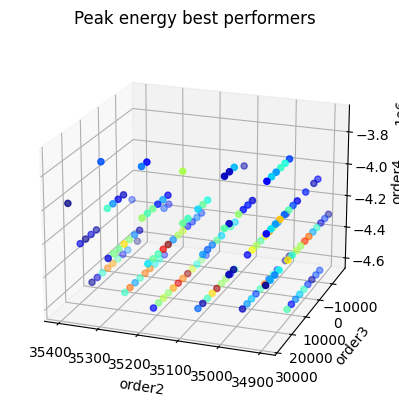

In [218]:
fig = plt.figure()
ax = fig.add_subplot(projection='3d')
ax.scatter(df_good_perf['order2'], df_good_perf['order3'], df_good_perf['order4'],c=df_good_perf['Emax mean'],cmap='jet')
ax.set_xlabel('order2')
ax.set_ylabel('order3')
ax.set_zlabel('order4')
#zticks = [1e-8, 1e-7, 1e-6, 1e-5, 1e-4, 1e-3]
#ax.set_zticks(np.log10(zticks))
#print(df_error)
#ax.set_zscale('log')
ax.view_init(elev=20., azim=110)
plt.title('Peak energy best performers')
plt.show()